In [58]:
import pandas as pd
from os import walk

In [59]:
datasets_names = []
path_df = '../datasets/original_files/'
for (dirpath, dirnames, filenames) in walk(path_df):
    datasets_names.extend(filenames)
    break
datasets_names

['austin-listings.csv.gz',
 'boston-listings.csv.gz',
 'denver-listings.csv.gz',
 'los_angeles-listings.csv.gz',
 'new_orleans-listings.csv.gz',
 'new_york_city-listings.csv.gz',
 'san_diego-listings.csv.gz']

In [60]:
dataFrame = False
first = True
for name in datasets_names:
    if(first):
        first = False
        dataFrame = pd.read_csv(path_df+name, compression='gzip')
        dataFrame.set_index('id', drop=False, inplace=True)
        print('adding', len(dataFrame), 'rows')
    else:
        _tmpDf = pd.read_csv(path_df+name, compression='gzip')
        _tmpDf.set_index('id', drop=False, inplace=True)
        print('adding', len(_tmpDf), 'rows')
        dataFrame = pd.concat([dataFrame, _tmpDf])
        del _tmpDf
print('total rows:', len(dataFrame))
dataFrame.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


adding 11668 rows
adding 3799 rows
adding 4868 rows
adding 38481 rows
adding 7211 rows


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


adding 50796 rows


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (43,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


adding 13927 rows
total rows: 130750


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
2265,2265,https://www.airbnb.com/rooms/2265,20200317143754,2020-03-17,Zen-East in the Heart of Austin (monthly rental),Zen East is situated in a vibrant & diverse mu...,This colorful and clean 1923 house was complet...,Zen East is situated in a vibrant & diverse mu...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.18
5245,5245,https://www.airbnb.com/rooms/5245,20200317143754,2020-03-17,"Eco friendly, Colorful, Clean, Cozy monthly share",Situated in a vibrant & diverse multicultural ...,"This green, colorful, clean and cozy house was...",Situated in a vibrant & diverse multicultural ...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.07
5456,5456,https://www.airbnb.com/rooms/5456,20200317143754,2020-03-17,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,Cute Private Studio apartment located in Willo...,Great central location for walking to Convent...,none,My neighborhood is ideally located if you want...,...,f,f,strict_14_with_grace_period,f,t,1,1,0,0,3.94
5769,5769,https://www.airbnb.com/rooms/5769,20200317143754,2020-03-17,NW Austin Room,NaN,Looking for a comfortable inexpensive room to ...,Looking for a comfortable inexpensive room to ...,none,Quiet neighborhood with lots of trees and good...,...,f,f,moderate,t,t,1,0,1,0,2.12
6413,6413,https://www.airbnb.com/rooms/6413,20200317143754,2020-03-17,Gem of a Studio near Downtown,"Great studio apartment, perfect for couples or...",!!!!! SXSW info !!!!! Presently open (again!) ...,"Great studio apartment, perfect for couples or...",none,Travis Heights is one of the oldest neighborho...,...,t,f,strict_14_with_grace_period,f,f,1,1,0,0,0.90


In [61]:
#cleaning columns
for x in dataFrame.columns:
    print(x)
    values = dataFrame[x][pd.notna(dataFrame[x])].values
    if(len(values) > 0):
        print(values[0])
    else:
        print('NOT_VALUES')
    print('')

id
2265

listing_url
https://www.airbnb.com/rooms/2265

scrape_id
20200317143754

last_scraped
2020-03-17

name
Zen-East in the Heart of Austin (monthly rental)

summary
Zen East is situated in a vibrant & diverse multicultural neighborhood, within walking distance of many great restaurants, cafes, performance/art spaces, UT campus, downtown & just a few miles from a beautiful trail ~ Ladybird Lake. NOTE: As of 1/20/18, new home construction with intermittent noise is happening at lot next door typically b/w hours of 8 - 5:30 pm. Exterior is 90% complete.

space
This colorful and clean 1923 house was completely remodeled in 2004. The house is a 2BR/ 2BA (1350 sq') with a pillow top queen bed in the large master with full private bath and a double futon bed (floor level) in an office which converts to a small guest room adjacent to a full bathroom in the hallway. The following amenities are included: CACH, WIFI, HDTV, washer/dryer, fully equipped kitchen, street parking, fenced back yar

f

cancellation_policy
strict_14_with_grace_period

require_guest_profile_picture
f

require_guest_phone_verification
f

calculated_host_listings_count
3

calculated_host_listings_count_entire_homes
2

calculated_host_listings_count_private_rooms
1

calculated_host_listings_count_shared_rooms
0

reviews_per_month
0.18



In [62]:
# neighbourhood
# neighbourhood_cleansed
# neighbourhood_group_cleansed
# guests_included
# license
# is_business_travel_ready

cols_to_drop = [
    'market', 'street',
    'listing_url', 'scrape_id', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url',
    'host_name', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
    'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'zipcode', 'smart_location', 'country_code',
    'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people',
    'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights',
    'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
    'requires_license','jurisdiction_names','host_location'
]
# [colName for colName in dataFrame.columns if colName not in cols_to_drop]


# dataFrame.drop(cols_to_drop, axis=1, inplace=True)

In [63]:
import numpy as np

In [64]:
# drop outliers
from scipy import stats
dataFrame.loc[:,  'price'] = dataFrame.price.apply(lambda x: x[1:-3].replace(',', '')).astype(int)
dataFrame = dataFrame[dataFrame.price!=0]
dataFrame = dataFrame[(dataFrame.number_of_reviews>2)]
dataFrame = dataFrame[(np.abs(stats.zscore(dataFrame[['price']])) < 3)]

In [65]:
len(dataFrame)

86250

In [66]:
#text pipeline steps
from sklearn.base import BaseEstimator, TransformerMixin

#Esta clase simplemente filtra las columnas que se le indica en el constructor
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self._feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self._feature_names ]
    
class TextTransformer(BaseEstimator, TransformerMixin):
    
    def __clean_text(self, x):
        for punct in "/-'":
            x = x.replace(punct, ' ')
        for punct in '&':
            x = x.replace(punct, f' {punct} ')
        for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~•' + '“”’':
            x = x.replace(punct, '')
        return x.lower()
    
    def __parseTextCols(self, x):
        finalTexts = []
        for i in x:
            if(pd.notna(i) and i not in finalTexts):
                finalTexts.append(i)
        text = self.__clean_text(' '.join(finalTexts))
        return text
    
    def fit(self, X, y = None):
        return self
    
    def transform (self, X, y = None):
        return X.apply(self.__parseTextCols, axis=1)
    
    
from sklearn.feature_extraction.text import TfidfVectorizer
class custom_Tfidf(TfidfVectorizer, TransformerMixin):
    options= {
        'fitSample': 1
    }
    def __init__(self, params, options = None):
        self.vectorizer = TfidfVectorizer(**params)
        if(options != None):
            for key in options.keys():
                self.options[key] = options[key]
        
    def fit(self, X, y = None):
        self.vectorizer.fit(X.sample(frac=self.options['fitSample']))
        return self
    
    def transform(self, X, y = None):
        return self.vectorizer.transform(X)

In [67]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

text_cols = ["name","summary","space","description","neighborhood_overview","notes","transit","access",
             "interaction","house_rules","host_about"]

from nltk.corpus import stopwords
stopwords_en = stopwords.words('english')
textVectSettings = {
    'stop_words': stopwords_en,
    'max_df': 0.95,
    'min_df': .05,
    'ngram_range': (1,2),
    'max_features': 300
}

#Pasos para el pipeline Textos
text_pipeline = Pipeline(steps = [
    ( 'text_selector', FeatureSelector(text_cols) ),
    ( 'text_transformer', TextTransformer() ),
    ( 'text_vectorize',  custom_Tfidf(textVectSettings, {'fitSample':1}))
] )

In [68]:
dummy_cols = ["instant_bookable","is_business_travel_ready","cancellation_policy",
"require_guest_phone_verification",
"require_guest_profile_picture","host_response_time",
"host_is_superhost","host_has_profile_pic","host_identity_verified",
"city","state","property_type","room_type","bed_type"];

from sklearn.impute import SimpleImputer

dummy_pipeline = Pipeline(steps = [
    ('dummy_selector', FeatureSelector(dummy_cols)),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [69]:
import numpy as np

class NumericalImputer(BaseEstimator, TransformerMixin):
    def __init__( self, default_strategy = "median"):
        self._default_strategy = default_strategy
        self._default_values = {}
        
    def fit( self, X, y = None ):
        X.host_response_rate = X.host_response_rate.str.replace('%', '').astype(float)
        X.host_acceptance_rate = X.host_acceptance_rate.str.replace('%', '').astype(float)
        
        #Si hay valores infinitos los convertimos en NaN
        X = X.replace( [ np.inf, -np.inf ], np.nan )
        
        for col in X.columns:
            if col=='number_of_reviews_ltm':
                default_value=0;
            elif col=='number_of_reviews':
                default_value=0;
            elif col=='host_listings_count':
                default_value=1;
            elif self._default_strategy=='median':
                default_value=np.median(X[col].dropna())
            elif self._default_strategy=='mode':
                default_value=np.mode(X[col].dropna())
            elif self._default_strategy=='mean':
                default_value=np.mean(X[col].dropna())
            else:
                default_value=np.median(X[col].dropna())
            self._default_values[col]=default_value

        return self 
    
    def transform(self, X, y = None):
        X.host_response_rate = X.host_response_rate.astype(str).str.replace('%', '').astype(float)
        X.host_acceptance_rate = X.host_acceptance_rate.astype(str).str.replace('%', '').astype(float)
        
        for col in X.columns:
            X[col] = X[col].astype(float)
            #Si hay valores infinitos los convertimos en NaN
            X[col] = X[col].replace( [ np.inf, -np.inf ], np.nan)
            X[col].fillna(self._default_values[col],inplace=True)
        return X

class NumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__( self, log_transform = True):
        self._log_transform = log_transform
        
    def fit( self, X, y = None ):
        return self 
    
    def transform(self, X, y = None):
        
        if self._log_transform:
            for col in X.columns:
                colname = col+"_log"
                X.loc[:,colname] = np.log(X[col]+1)
                
        #Retornamos un array de Numpy ?
        return X
    
class NumericalAddFeatures(BaseEstimator, TransformerMixin):
    def __init__( self, bath_per_bed = True, bath_per_bedroom = True ):
        self._bath_per_bed = bath_per_bed
        self._bath_per_bedroom = bath_per_bedroom
        
    def fit( self, X, y = None ):
        return self 
    
    def transform(self, X, y = None):
        if self._bath_per_bedroom:
            X.loc[X['bedrooms']==0,'bedrooms']=1;
            X['bath_per_bedroom'] = X['bathrooms'] / X['bedrooms']
        if self._bath_per_bed:
            X.loc[X['beds']==0,'beds']=1;
            X['bath_per_bed'] = X['bathrooms'] / X['beds']
        
        # ejemplo para clasificar valores
        #pd.cut(df.Age,bins=[0,2,17,65,99],labels=['Toddler/Baby','Child','Adult','Elderly'])
        
        #Retornamos un array de Numpy ?
        return X

In [70]:
continuos_cols = [
    "reviews_per_month","host_response_rate","host_acceptance_rate",
    "review_scores_communication","review_scores_location","review_scores_value",
    "number_of_reviews_ltm","review_scores_rating","review_scores_cleanliness",
    "review_scores_checkin","availability_30","availability_60","availability_90","availability_365",
    "review_scores_accuracy","minimum_nights","maximum_nights",
    "calculated_host_listings_count","calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms","calculated_host_listings_count_shared_rooms",
    "host_listings_count","number_of_reviews",
    "accommodates","bathrooms","bedrooms","beds","guests_included",
]


numerical_pipeline = Pipeline( steps = [
    ( 'num_selector', FeatureSelector(continuos_cols) ),
    ( 'num_imputer', NumericalImputer(default_strategy = 'median') ),
    ( 'num_transformer', NumericalTransformer() ),
    ( 'std_scaler', StandardScaler() ) 
])

In [71]:


full_pipeline = FeatureUnion( transformer_list = [ 
    ('numerical_pipeline', numerical_pipeline ),
    ('dummy_pipeline', dummy_pipeline ),
    ('text_pipeline', text_pipeline ),
] )

In [72]:
from sklearn.model_selection import train_test_split

# y = dataFrame.price.apply(lambda x: x[1:-3].replace(',', '')).astype(int)
y = dataFrame.price
X = dataFrame.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.head()

# full_pipeline.fit(dataFrame)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
41014030,41014030,https://www.airbnb.com/rooms/41014030,20200317212944,2020-03-18,《Luxury Suite》Spacious New Renovation | Park Free,"Recently remodeled and tastefully furnished, t...","Recently remodeled and tastefully furnished, t...","Recently remodeled and tastefully furnished, t...",none,The neighborhood is quiet & family-oriented. I...,...,t,f,flexible,f,f,5,0,4,1,10.81
30446884,30446884,https://www.airbnb.com/rooms/30446884,20200317143754,2020-03-17,Large remodeled eastside home 3 mi. from downtown,Newly remodeled large house in east Austin. Ju...,2019 remodel with ample street and driveway pa...,Newly remodeled large house in east Austin. Ju...,none,One of the original neighborhoods in Austin. L...,...,f,f,strict_14_with_grace_period,f,f,1,0,1,0,0.57
33808465,33808465,https://www.airbnb.com/rooms/33808465,20200313233810,2020-03-14,Access to public transportation Near shopping ...,Very clean house and there’s always parking al...,The bedroom both bathrooms kitchen&dining room,Very clean house and there’s always parking al...,none,Near public transportation shopping area easy ...,...,t,f,flexible,f,f,1,0,1,0,1.73
37386681,37386681,https://www.airbnb.com/rooms/37386681,20200316134736,2020-03-16,Brigham Circle 3-Bedroom Apt on T Subway Station,Centrally located at the bustling Brigham Circ...,Quiet apartment conveniently off central busin...,Centrally located at the bustling Brigham Circ...,none,On the end of a cul de sac street right off th...,...,f,f,moderate,f,f,5,2,3,0,2.68
28396091,28396091,https://www.airbnb.com/rooms/28396091,20200313233908,2020-03-14,STUDIO 11 IN MULTIMEDIA BUILDING AVAILABLE TO ...,Nice room to rest in the heart of Hollywood Ca...,NaN,Nice room to rest in the heart of Hollywood Ca...,none,NaN,...,t,f,strict_14_with_grace_period,f,f,18,3,15,0,0.47


In [73]:
full_pipeline.fit(X_train)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

FeatureUnion(n_jobs=None,
       transformer_list=[('numerical_pipeline', Pipeline(memory=None,
     steps=[('num_selector', FeatureSelector(feature_names=None)), ('num_imputer', NumericalImputer(default_strategy=None)), ('num_transformer', NumericalTransformer(log_transform=None)), ('std_scaler', StandardScaler(copy=True, with_mea...er', TextTransformer()), ('text_vectorize', custom_Tfidf(options={'fitSample': 1}, params=None))]))],
       transformer_weights=None)

In [74]:
train_data = full_pipeline.transform(X_train)
train_targets = y_train

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [75]:
train_data.shape

(57787, 1024)

In [76]:
validation_data = full_pipeline.transform(X_test)
validation_targets = y_test

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [77]:
# train_targets
pd.Series(np.log(train_targets), index=train_targets.index)

id
41014030    3.806662
30446884    5.703782
33808465    4.605170
37386681    5.700444
28396091    3.496508
15498187    5.010635
3662860     4.867534
21097466    4.499810
38949408    4.700480
38778700    4.317488
34369358    3.806662
19367013    4.736198
2979097     4.753590
37626398    4.828314
6071529     5.192957
18489187    6.850126
7744805     5.030438
34224584    5.686975
32364880    5.783825
38001341    4.779123
14757774    4.094345
29737550    4.744932
13401235    5.036953
31543246    4.905275
37798246    3.871201
23118427    6.390241
39028280    4.691348
39355550    4.248495
10619457    4.574711
27954309    5.075174
              ...   
27491585    3.806662
18821462    4.553877
18405855    4.553877
9433839     5.010635
34934376    4.976734
21838665    3.784190
36062007    4.094345
26364147    4.553877
38269196    4.234107
10423038    4.234107
29187379    5.010635
31906748    4.488636
30450834    3.367296
26199962    5.153292
23017828    4.094345
19505956    5.105945
3534046   

In [104]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.layers import Dropout
from keras import optimizers
from keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model = Sequential()
# model.add(Dense(1500, activation='relu', input_shape=(train_data.shape[1],)))
# model.add(Dropout(0.5))
# model.add(Dense(1500, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1500, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1500, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1500, activation='relu'))
# model.add(Dropout(0.5))


model.add(Dense(100, activation='relu', input_shape=(train_data.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', r2_keras])
# mean_squared_logarithmic_error
# mean_squared_error
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 60)                61500     
_________________________________________________________________
dropout_24 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 60)                3660      
_________________________________________________________________
dropout_25 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 61        
Total params: 65,221
Trainable params: 65,221
Non-trainable params: 0
_________________________________________________________________


In [105]:
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=25, restore_best_weights=True, verbose=1)
callbacks_list = [early_stopping, reduce_lr]

model.optimizer.learning_rate.assign(0.001)

history = model.fit(
    train_data,
    train_targets,
    epochs=100,
    batch_size=500,
    verbose=1,
    callbacks=callbacks_list,
    validation_split=.25
)

Train on 43340 samples, validate on 14447 samples
Epoch 1/100
43340/43340 [==============================] - 1s 25us/step - loss: 49479.5358 - mae: 139.8002 - r2_keras: -0.5949 - val_loss: 28962.0399 - val_mae: 83.7708 - val_r2_keras: 0.0345
Epoch 2/100
43340/43340 [==============================] - 1s 21us/step - loss: 22149.2393 - mae: 78.4636 - r2_keras: 0.2912 - val_loss: 17049.5839 - val_mae: 68.0830 - val_r2_keras: 0.4376
Epoch 3/100
43340/43340 [==============================] - 1s 21us/step - loss: 19082.7423 - mae: 73.5668 - r2_keras: 0.3908 - val_loss: 15820.1133 - val_mae: 64.9379 - val_r2_keras: 0.4786
Epoch 4/100
43340/43340 [==============================] - 1s 21us/step - loss: 17826.2505 - mae: 69.7511 - r2_keras: 0.4313 - val_loss: 14776.5534 - val_mae: 61.0565 - val_r2_keras: 0.5136
Epoch 5/100
43340/43340 [==============================] - 1s 21us/step - loss: 17091.7389 - mae: 67.7324 - r2_keras: 0.4522 - val_loss: 14005.8474 - val_mae: 58.5181 - val_r2_keras: 0.539

Epoch 44/100
43340/43340 [==============================] - 1s 22us/step - loss: 12467.7358 - mae: 56.6060 - r2_keras: 0.5963 - val_loss: 10374.8642 - val_mae: 48.8411 - val_r2_keras: 0.6585
Epoch 45/100
43340/43340 [==============================] - 1s 22us/step - loss: 12485.4583 - mae: 56.4078 - r2_keras: 0.6007 - val_loss: 10360.2539 - val_mae: 48.8653 - val_r2_keras: 0.6590
Epoch 46/100
43340/43340 [==============================] - 1s 21us/step - loss: 12518.3131 - mae: 56.1860 - r2_keras: 0.5968 - val_loss: 10377.1630 - val_mae: 48.8064 - val_r2_keras: 0.6583
Epoch 47/100
43340/43340 [==============================] - 1s 21us/step - loss: 12369.2419 - mae: 56.0189 - r2_keras: 0.6009 - val_loss: 10411.2777 - val_mae: 48.8050 - val_r2_keras: 0.6573
Epoch 48/100
43340/43340 [==============================] - 1s 21us/step - loss: 12256.0813 - mae: 55.7902 - r2_keras: 0.6080 - val_loss: 10320.9105 - val_mae: 48.7632 - val_r2_keras: 0.6599
Epoch 49/100
43340/43340 [===================

43340/43340 [==============================] - 1s 22us/step - loss: 11297.2962 - mae: 53.5233 - r2_keras: 0.6373 - val_loss: 10052.1752 - val_mae: 48.5362 - val_r2_keras: 0.6683
Epoch 86/100
43340/43340 [==============================] - 1s 21us/step - loss: 11417.9183 - mae: 53.7363 - r2_keras: 0.6298 - val_loss: 10076.1865 - val_mae: 48.4387 - val_r2_keras: 0.6676
Epoch 87/100
43340/43340 [==============================] - 1s 21us/step - loss: 11411.4885 - mae: 53.9620 - r2_keras: 0.6307 - val_loss: 10070.6694 - val_mae: 48.4612 - val_r2_keras: 0.6678
Epoch 88/100
43340/43340 [==============================] - 1s 21us/step - loss: 11419.0160 - mae: 53.6368 - r2_keras: 0.6320 - val_loss: 10057.5826 - val_mae: 48.5089 - val_r2_keras: 0.6681

Epoch 00088: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 89/100
43340/43340 [==============================] - 1s 21us/step - loss: 11394.2212 - mae: 53.6818 - r2_keras: 0.6356 - val_loss: 10044.1598 - val_mae: 48.5550 -

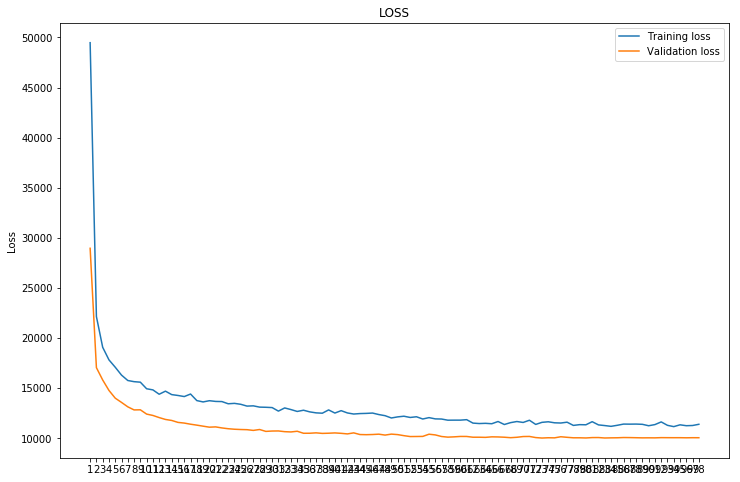

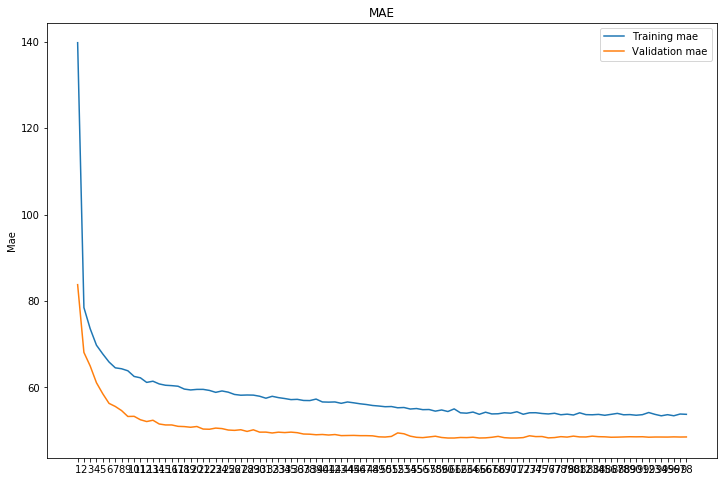

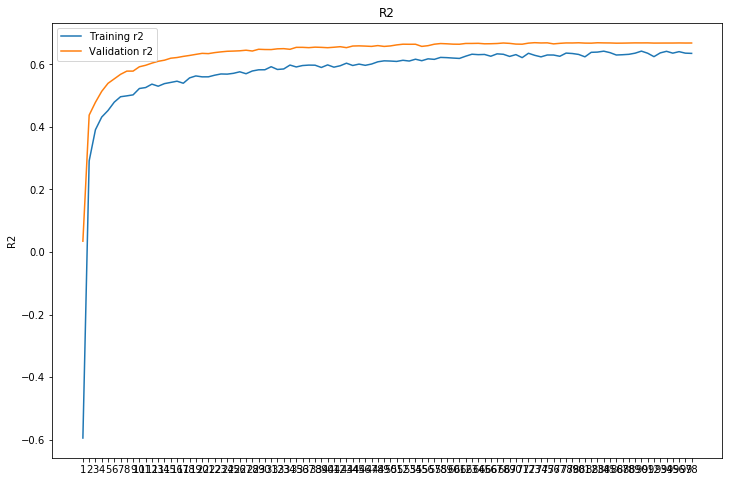

In [107]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.title('LOSS')
plt.plot(epochs, loss)
# plt.ylim((None, .5))
plt.plot(epochs, val_loss)
plt.xticks(ticks=epochs)
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'])
plt.show()

mae = history.history['mae']
val_mae = history.history['val_mae']
plt.figure(figsize=(12,8))
plt.title('MAE')
plt.plot(epochs, mae)
plt.plot(epochs, val_mae)
plt.xticks(ticks=epochs)
plt.ylabel('Mae')
plt.legend(['Training mae', 'Validation mae'])
plt.show()


acc = history.history['r2_keras']
val_acc = history.history['val_r2_keras']
plt.figure(figsize=(12,8))
plt.title('R2')
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.xticks(ticks=epochs)
plt.ylabel('R2')
# plt.ylim((.6, None))
plt.legend(['Training r2', 'Validation r2'])
plt.show()

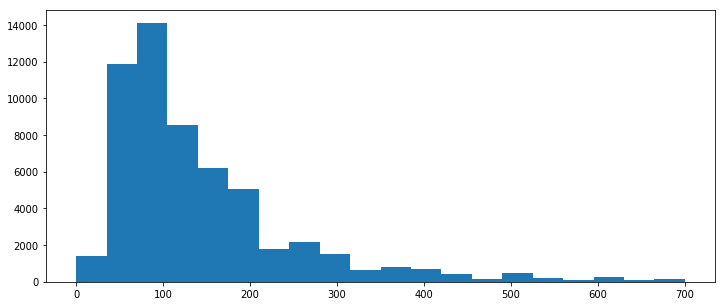

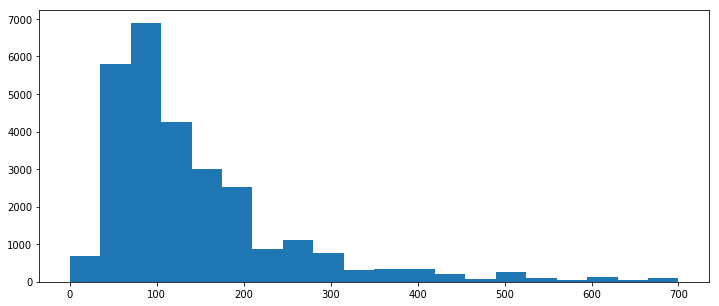

In [81]:
plt.figure(figsize=(12,5))
plt.hist(train_targets, bins=20, range=(0, 700))
plt.show()

plt.figure(figsize=(12,5))
plt.hist(validation_targets, bins=20, range=(0, 700))
plt.show()

In [82]:
history.history['mae'][-1]
# 66.35355
# 66.218636
# 59.322807
# 65.16372
# 68.29044
# 50.142715

0.6079459

In [92]:
y_predicted = model.predict(train_data)
# y_predicted = np.exp(y_predicted_log)

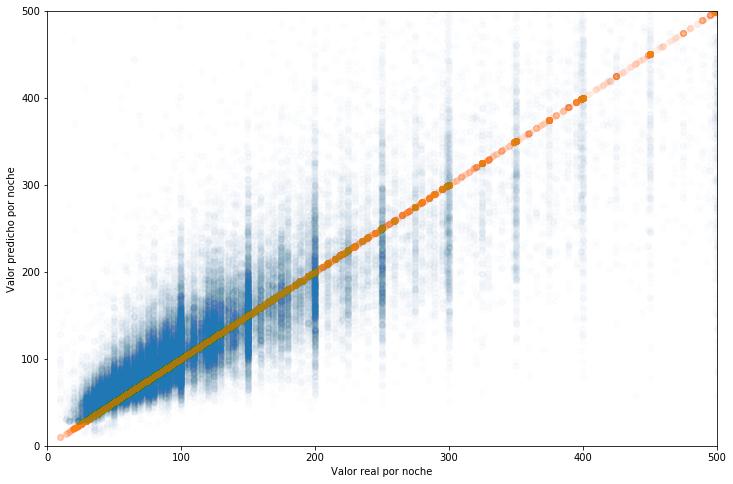

In [103]:
plt.figure(figsize=(12,8))
plt.scatter(train_targets, y_predicted, alpha=.01)
plt.scatter(train_targets, train_targets, alpha=.01)
plt.xlabel('Valor real por noche')
plt.ylabel('Valor predicho por noche')

lims = (0, 500)
plt.xlim(lims)
plt.ylim(lims)
plt.show()